In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import time
import requests
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from PIL import Image
#import streamlit as st


In [4]:
df = pd.read_csv('data/data_from_iNaturalist/observations.csv')
print(f"Исходный размер датасета: {df.shape}")

keep_columns = [
    'id',
    'image_url',
    'scientific_name',
    'taxon_id'
]
df = df[keep_columns].copy()

def generalize_name(name):
    if pd.isna(name):
        return name
    parts = name.split()
    return " ".join(parts[:2])

df['scientific_name'] = df['scientific_name'].apply(generalize_name)

allowed_species = [
    'Panthera leo',
    'Panthera pardus',
    'Panthera onca',
    'Panthera tigris',
    'Panthera uncia'
]

df = df[df['scientific_name'].isin(allowed_species)]

df = df.dropna(subset=['image_url', 'scientific_name'])
#df = df.dropna()
df.to_csv('data/dataset.csv', index=False)

print("-" * 30)
print("Итоговые классы:")
unique_classes = df['scientific_name'].unique()
print(unique_classes)
print(f"\nКоличество классов: {len(unique_classes)}")
print("-" * 30)
print(f"Размер очищенного датасета: {df.shape}")

Исходный размер датасета: (5610, 40)
------------------------------
Итоговые классы:
['Panthera leo' 'Panthera onca' 'Panthera tigris' 'Panthera pardus'
 'Panthera uncia']

Количество классов: 5
------------------------------
Размер очищенного датасета: (5602, 4)


## Конфигурации


In [ ]:
CSV_FILE = 'data/dataset.csv'
DATA_PATH = 'data/dataset_images'
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 1
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("mps") if torch.backends.mps.is_available() else "cpu" # Для Mac

print(f"Используем устройство: {DEVICE}")


#  БЛОК СКАЧИВАНИЯ ИЗОБРАЖЕНИЙ
def download_images(csv_path, output_dir):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Файл {csv_path} не найден! Сначала создайте dataset.csv.")

    df = pd.read_csv(csv_path)
    print(f"Найдено {len(df)} записей в CSV. Начинаем проверку/скачивание...")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    session = requests.Session()
    success_count = 0

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Скачивание"):
        img_url = row['image_url']
        class_name = row['scientific_name'].replace(" ", "_")
        img_id = row['id']

        class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        file_path = os.path.join(class_dir, f"{img_id}.jpg")

        if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
            success_count += 1
            continue

        try:
            response = session.get(img_url, timeout=10)
            if response.status_code == 200:
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                success_count += 1
            #
            # time.sleep(0.05)
        except Exception as e:
            # print(f"Ошибка скачивания {img_url}: {e}")
            pass

    print(f"Готово! Доступно изображений: {success_count}/{len(df)}")

download_images(CSV_FILE, DATA_PATH)


Используем устройство: cpu
Найдено 5602 записей в CSV. Начинаем проверку/скачивание...


Скачивание: 100%|██████████| 5602/5602 [00:14<00:00, 378.89it/s]

Готово! Доступно изображений: 5602/5602


## Аназиз (EDA)

Найдено классов: 5

Количество изображений по классам:
- Panthera_leo: 2110
- Panthera_onca: 981
- Panthera_pardus: 1667
- Panthera_tigris: 727
- Panthera_uncia: 117


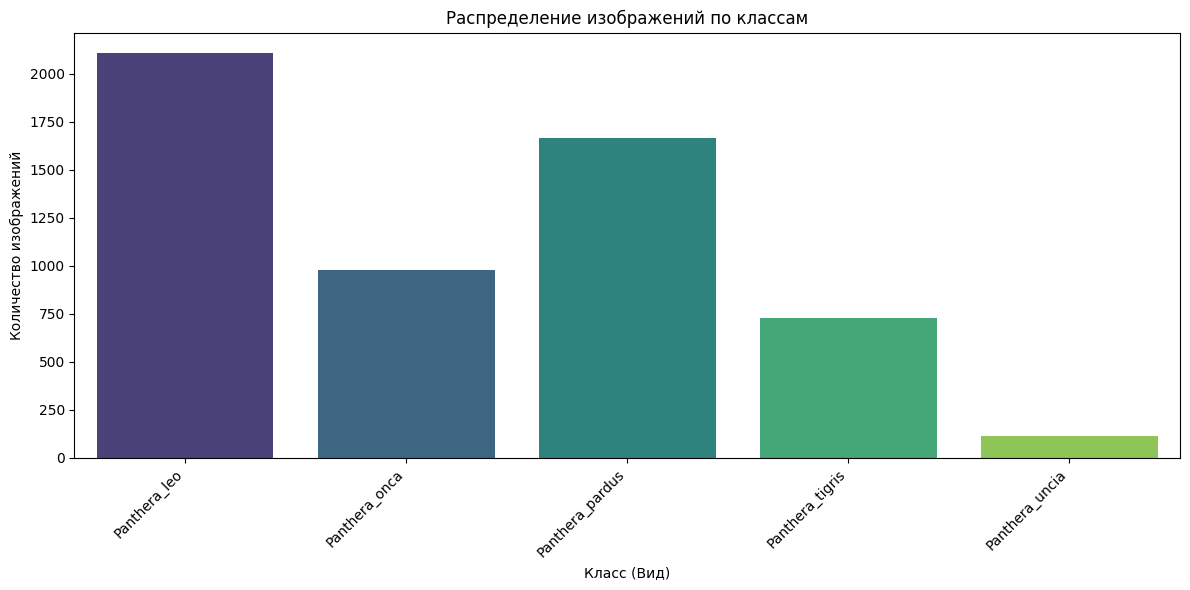


Примеры изображений из датасета:


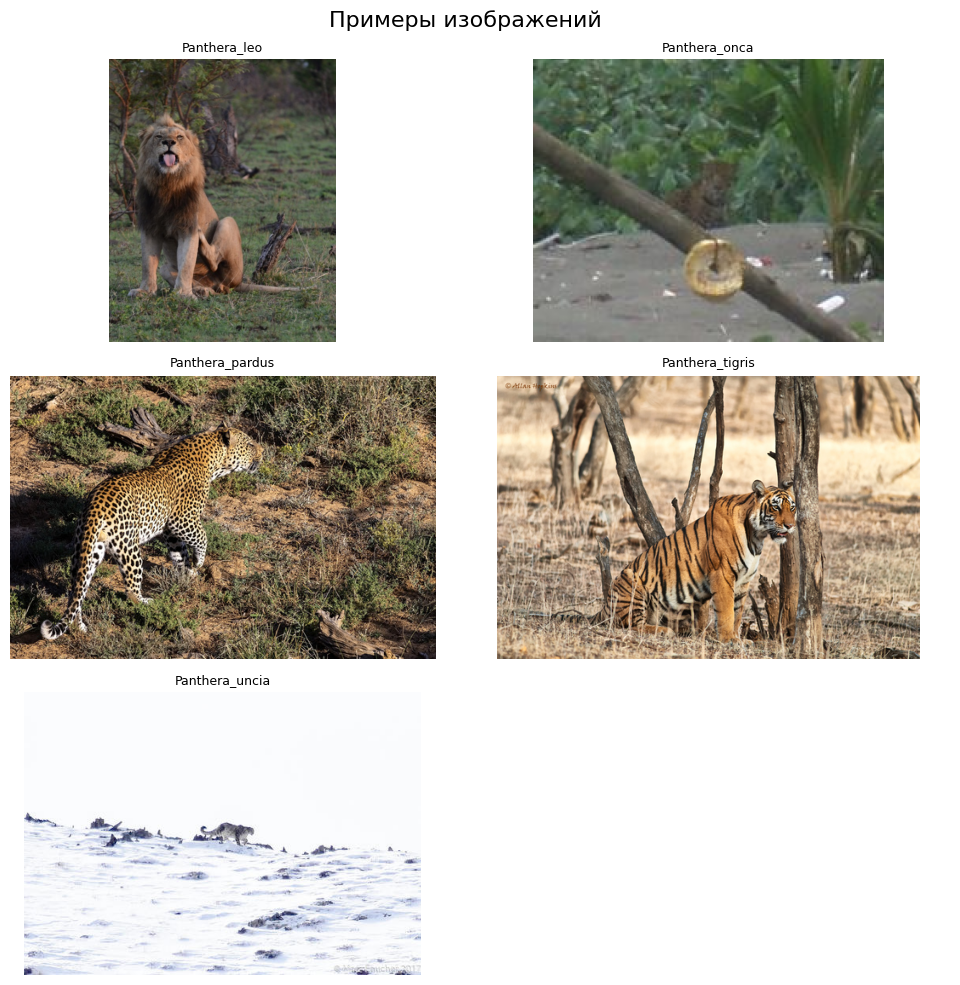

In [6]:
path_obj = Path(DATA_PATH)
class_names = [d.name for d in path_obj.iterdir() if d.is_dir()]
class_names.sort()
num_classes = len(class_names)

print(f"Найдено классов: {num_classes}")
class_counts = {name: len(list((path_obj / name).glob('*.jpg'))) for name in class_names}

print("\nКоличество изображений по классам:")
for name, count in class_counts.items():
    print(f"- {name}: {count}")

plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis", hue=list(class_counts.keys()), legend=False)
plt.title('Распределение изображений по классам')
plt.xlabel('Класс (Вид)')
plt.ylabel('Количество изображений')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print("\nПримеры изображений из датасета:")
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Примеры изображений', fontsize=16)
flattened_axes = axes.flatten()

for i, ax in enumerate(flattened_axes):
    if i >= len(class_names):
        ax.axis('off')
        continue

    class_name = class_names[i]
    folder_path = path_obj / class_name

    try:
        sample_image_path = next(folder_path.glob('*.jpg'))
        img = Image.open(sample_image_path)
        ax.imshow(img)
        ax.set_title(class_name, fontsize=9)
        ax.axis('off')
    except StopIteration:
        ax.text(0.5, 0.5, "Нет фото", ha='center', va='center')
        ax.set_title(class_name)
        ax.axis('off')

plt.tight_layout()
plt.show()

## Подготовка данных для обучения

In [7]:
print("Подготовка данных для обучения")
# Трансформации
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    #T.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    #T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    #T.RandomHorizontalFlip(),
    #T.RandomRotation(15),
    #T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(root=DATA_PATH)

if len(full_dataset) == 0:
    print(" === Датасет пуст =====.")
    exit()

print(f"Всего изображений: {len(full_dataset)}")
print(f"Классов: {len(full_dataset.classes)}")

# Разделение выборки: 70% train, 15% val, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Обертка для применения разных трансформаций
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, transform=train_transform)
val_dataset = TransformedDataset(val_subset, transform=val_test_transform)
test_dataset = TransformedDataset(test_subset, transform=val_test_transform)

# Dataloaders
# num_workers=0 для совместимости с Windows. На Linux можно ставить 2 или 4.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Подготовка данных для обучения
Всего изображений: 5602
Классов: 5


## 4. МОДЕЛЬ (EfficientNet V2)
Почему: Это современная архитектура (от Google), которая оптимизирована работать быстрее и точнее, чем классические ResNet. Она использует Transfer Learning (перенос обучения).
Я загрузил веса, обученные на ImageNet, и дообучил на целевых данных. Это даст результат гораздо быстрее, чем обучение с нуля.

In [8]:
print("Инициализация EfficientNet V2 Small")

weights = models.EfficientNet_V2_S_Weights.DEFAULT
model = models.efficientnet_v2_s(weights=weights)

num_classes = len(full_dataset.classes)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(DEVICE)

# Loss и Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

Инициализация EfficientNet V2 Small
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 164MB/s]


## Дообучение (Fine-tuning)

In [9]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(loader, leave=False, desc="Train")

    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f"Loss: {loss.item():.4f}")

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

print(f"\nНачинаем обучение на {NUM_EPOCHS} эпох")
best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f"\nОбучение завершено. Лучшая точность валидации: {best_acc:.2f}%")


Начинаем обучение на 1 эпох


Epoch 1/1 -> Train Loss: 0.5936 Acc: 77.71% | Val Loss: 0.4617 Acc: 82.26%

Обучение завершено. Лучшая точность валидации: 82.26%


## Тестирование


In [12]:
print("Загрузка лучшей модели и тестирование")
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
test_loss, test_acc = evaluate(model, test_loader)
print(f"Точность на Test: {test_acc:.2f}%")

Загрузка лучшей модели и тестирование
Точность на Test: 83.71%
